+++++<br>
Updated November 13, 2022<br>
Census Bureau API<br>
Author: Kailei Lin<br>
ACS Demographics <br>
+++++<br>

In [1]:
import os
import pandas as pd
import requests
import json
import re
from tqdm import tqdm
import time
import numpy as np
idx = pd.IndexSlice
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import datetime as dt
from dateutil.relativedelta import relativedelta
from openpyxl import load_workbook
import sqlite3
import sys
from functools import reduce


pd.set_option('display.max_colwidth', None)

In [2]:
today_date = dt.date.today().strftime('%Y_%m_%d')

In [3]:
desktop_path = os.path.join(os.path.join(os.path.expanduser('~')), 'Desktop') 
database_path = desktop_path+'/Users/beaconeconomics/Desktop/Escondido Database'
city_path = database_path +'/City'
county_path = database_path +'/County'

city_path

'/Users/beaconeconomics/Desktop/Users/beaconeconomics/Desktop/Escondido Database/City'

In [4]:
# 1. ACS Variables

In [4]:
df_vars = pd.read_html('https://api.census.gov/data/2021/acs/acs1/variables.html')
df_vars = df_vars[0]
df_vars.head(2)

,Name,Label,Concept,Required,Attributes,Limit,Predicate Type,Group,Unnamed: 8
0,AIANHH,Geography,NaN,not required,NaN,0,(not a predicate),NaN,NaN
1,ANRC,Geography,NaN,not required,NaN,0,(not a predicate),NaN,NaN


In [7]:
# 2. Search ACS Variables

In [6]:
def search_variable(df,terms):
    mask = df['Label'].str.contains(terms)
    df = df[mask]
    
    return df 

In [20]:
acs = search_variable(df_vars,('pop'))

# 3. ACS At County LEVEL

In [9]:
county = '&for=county:*&'

In [ ]:
city = '&for=place:*&'

In [ ]:
race = ['B03002_002E']

In [13]:
class api_fetch_county:   
    def __init__(self, variable_name, entity, database, year):
        
        self.year = year
        self.base = f'https://api.census.gov/data/{self.year}/acs/'
        self.api_base = self.base+database
        self.api_key = 'key=f7dbd2643e469dbe6f554b59ce1c907674ac9930'
        self.variable_name = "?&get=NAME,"+variable_name + entity
        
        self.api_final = f'{self.api_base}{self.variable_name}{self.api_key}'
        
    def request(self):
        return requests.get(self.api_final)
    
    def download(self):
        r = requests.get(self.api_final)
        data = r.json()
        df = pd.DataFrame(data)
        df = df.rename(columns=df.iloc[0]).drop(df.index[0])
        df = pd.concat([df.NAME, df.loc[:, ~df.columns.isin(['NAME'])].astype(float)],axis=1)
        return df


In [ ]:
# labor force pull

In [42]:
start_year = 2011
data_lf = []
for year in range(start_year, 2022):
    df = api_fetch_city('B23025_002E', county, 'acs5', str(year)).download()
    #df = df.loc[mask]#.drop(['state','place'],axis=1)#.set_index('NAME')
    df['year'] = str(year)
    data_lf.append(df)

In [43]:
data_lf_concated = pd.concat(data_lf,axis=0)

In [44]:
data_lf_concated

,NAME,B23025_002E,state,county,year
1,"Sweetwater County, Wyoming",23634.0,56.0,37.0,2011
2,"Platte County, Wyoming",4315.0,56.0,31.0,2011
3,"Sheridan County, Wyoming",15513.0,56.0,33.0,2011
4,"Big Horn County, Wyoming",5671.0,56.0,3.0,2011
5,"Crook County, Wyoming",3511.0,56.0,11.0,2011
...,...,...,...,...,...
3217,"Vega Baja Municipio, Puerto Rico",19808.0,72.0,145.0,2021
3218,"Vieques Municipio, Puerto Rico",2355.0,72.0,147.0,2021
3219,"Villalba Municipio, Puerto Rico",7858.0,72.0,149.0,2021
3220,"Yabucoa Municipio, Puerto Rico",9897.0,72.0,151.0,2021


In [ ]:
# County data final merge 

In [168]:
data_acs_merge2 = data_acs_merge1.merge(data_lf_concated, left_on=['NAME','state',
       'county', 'year'], right_on=['NAME','state',
       'county', 'year'], how='left')

In [ ]:
# Check if the education attainment is correctly merged

In [169]:
ca_acs_merge2 = data_acs_merge2[data_acs_merge2.state==6]

In [170]:
ca_acs_merge2[100:]

,NAME,B25008_003E,B03002_012M,B25106_028E,B07009_006E,B19025_001E,B19301_001E,B19326_001E,B03002_001E,B01003_001M,...,Percent!!SEX AND AGE!!Total population!!20 to 24 years,Percent!!SEX AND AGE!!Total population!!55 to 59 years,Percent!!SEX AND AGE!!Total population!!25 to 34 years,Percent!!SEX AND AGE!!Total population!!45 to 54 years,Percent Margin of Error!!COMMUTING TO WORK!!Workers 16 years and over!!Worked at home,Percent!!SEX AND AGE!!Total population!!60 to 64 years,Percent Estimate!!SEX AND AGE!!Total population!!15 to 19 years,Percent!!SEX AND AGE!!Total population!!35 to 44 years,Percent Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Worked at home,B23025_002E
5568,"Marin County, California",83635.0,-555555555.0,5490.0,41513.0,1.344040e+10,54605.0,42581.0,250666.0,-555555555.0,...,4.2,8.5,9.7,16.8,0.7,7.3,5.1,14.9,9.9,133482.0
5569,"Placer County, California",88625.0,-555555555.0,6056.0,25790.0,1.206033e+10,35583.0,35835.0,343554.0,-555555555.0,...,5.3,6.6,11.1,15.3,0.5,5.9,6.9,13.7,7.5,172232.0
5570,"Siskiyou County, California",15674.0,-555555555.0,2257.0,2395.0,9.914947e+08,22335.0,19955.0,44687.0,-555555555.0,...,4.8,8.5,9.2,15.7,1.2,8.7,6.4,10.5,7.8,19576.0
5571,"Shasta County, California",59582.0,-555555555.0,7048.0,7934.0,4.074526e+09,23691.0,22061.0,177231.0,-555555555.0,...,6.3,7.5,11.0,15.0,0.6,6.6,7.1,11.6,5.7,79497.0
5572,"Solano County, California",137944.0,-555555555.0,8910.0,19363.0,1.178616e+10,29367.0,31850.0,411620.0,-555555555.0,...,7.0,6.4,13.3,15.4,0.4,5.6,7.5,13.5,3.8,210594.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34240,"Tulare County, California",202826.0,-555555555.0,11496.0,13985.0,1.083181e+10,23706.0,26619.0,470999.0,-555555555.0,...,7.0,5.2,14.1,11.0,0.5,4.7,8.3,12.9,4.9,209013.0
34241,"Tuolumne County, California",12242.0,-555555555.0,1243.0,3579.0,2.041272e+09,37042.0,32647.0,55243.0,-555555555.0,...,5.1,7.4,12.2,11.5,2.0,8.5,4.3,10.9,9.2,23439.0
34242,"Ventura County, California",305204.0,-555555555.0,9859.0,71564.0,3.401502e+10,41863.0,37359.0,845255.0,-555555555.0,...,6.5,7.1,13.3,13.1,0.5,6.3,6.7,12.6,10.7,438224.0
34243,"Yolo County, California",99051.0,-555555555.0,6621.0,26840.0,8.289799e+09,38805.0,34534.0,216703.0,-555555555.0,...,13.8,5.3,13.4,10.7,1.0,5.0,10.0,12.0,12.5,107978.0


In [ ]:
# Clean County data 

In [171]:
county_database = data_acs_merge2

In [92]:
# County data map columns

In [172]:
county_database = county_database.rename(columns=county_codes)

In [173]:
county_database = county_database.rename(columns=county_codes_11_16)

In [ ]:
# Calculate Necessary data columns #
# ************ income per capita ************ #
# ************ latino share  ************ #
# ************ % share with University degree ************ #
# ************ % Share age between 20 and 59 ************ #

In [175]:
county_database['Percent Total Population 20 to 59 years'] = county_database['Percent!!SEX AND AGE!!Total population!!25 to 34 years']+county_database['Percent!!SEX AND AGE!!Total population!!35 to 44 years']+county_database['Percent!!SEX AND AGE!!Total population!!45 to 54 years']+county_database['Percent!!SEX AND AGE!!Total population!!55 to 59 years']+county_database['Percent!!SEX AND AGE!!Total population!!20 to 24 years']

In [176]:
county_database['Total Population 20 to 59 years'] = (county_database['Percent Total Population 20 to 59 years']/100)*county_database['Total Population']

In [178]:
county_database['Income per capita Prime age'] = county_database['Aggregate household income']/county_database['Total Population 20 to 59 years'] 

In [179]:
county_database['latino share%'] = round((county_database['Hispanic or Latino']/county_database['pop_race'])*100,2)

In [180]:
county_database['Population with College degree'] = county_database['Some college or associate Degree'] +county_database['Bachelor degree']+county_database['Graduate or professional degree']

In [181]:
county_database['University Degree share'] = round((county_database['Population with College degree']/county_database['Total Population'])*100,2)

In [182]:
county_database['Renting population share'] = round((county_database['pop_Renters']/county_database['Total Population'])*100,2)


# 3. ACS At CITY LEVEL

https://downloads.esri.com/esri_content_doc/dbl/us/Var_List_ACS_Summer2021.pdf

In [ ]:
# 2009 - 2015

In [15]:
class api_fetch_city:   
    def __init__(self, variable_name, entity, database, year):
        
        self.year = year
        self.base = f'https://api.census.gov/data/{self.year}/acs/'
        self.api_base = self.base+database
        self.api_key = 'key=f7dbd2643e469dbe6f554b59ce1c907674ac9930'
        self.variable_name = "?&get=NAME,"+variable_name + entity
        
        self.api_final = f'{self.api_base}{self.variable_name}{self.api_key}'
        
    def request(self):
        return requests.get(self.api_final)
    
    def download(self):
        r = requests.get(self.api_final)
        data = r.json()
        df = pd.DataFrame(data)
        df = df.rename(columns=df.iloc[0]).drop(df.index[0])
        df = pd.concat([df.NAME, df.loc[:, ~df.columns.isin(['NAME'])].astype(float)],axis=1)
        return df

In [16]:
# 2016-2019

In [17]:
class api_fetch_city_new:   
    def __init__(self, variable_name, entity, database, year):
        
        self.year = year
        self.base = f'https://api.census.gov/data/{self.year}/acs/'
        self.api_base = self.base+database
        self.api_key = 'key=f7dbd2643e469dbe6f554b59ce1c907674ac9930'
        self.variable_name = "?&get=NAME,"+variable_name + entity
        
        self.api_final = f'{self.api_base}{self.variable_name}{self.api_key}'
        
    def request(self):
        
        return requests.get(self.api_final)
    
    def download(self):
        with requests.get('http://httpbin.org/get', stream=True) as r:
            r = requests.get(self.api_final)
            data = r.json()
            df = pd.DataFrame(data)
            df = df.rename(columns=df.iloc[0]).drop(df.index[0])
            df = pd.concat([df.NAME, df.loc[:, ~df.columns.isin(['NAME'])].astype(float)],axis=1)
        return df


In [7]:
## Testing if acs code exists within geographies 

In [8]:
# Labor Force by Industry #

In [19]:
city = '&for=place:*&'
df = api_fetch_city('B01001_001E', county, 'acs1', str(2021)).download()
mask = df.state == 6
df = df.loc[mask, :]
df


,NAME,B01001_001E,state,county
240,"Kings County, California",153443.0,6.0,31.0
241,"Los Angeles County, California",9829544.0,6.0,37.0
242,"Napa County, California",136207.0,6.0,55.0
243,"Orange County, California",3167809.0,6.0,59.0
244,"Riverside County, California",2458395.0,6.0,65.0
245,"San Bernardino County, California",2194710.0,6.0,71.0
246,"San Joaquin County, California",789410.0,6.0,77.0
247,"Santa Barbara County, California",446475.0,6.0,83.0
250,"Shasta County, California",182139.0,6.0,89.0
251,"Solano County, California",451716.0,6.0,95.0


In [27]:
data = data.rename(columns={'B19083_001E':'Gini Index'})

In [94]:
north = ['Del Mar','Oceanside','Escondido','Encinitas','Solana Beach','Poway','Vista','San Marcos','San Diego']

In [29]:
peer = [
    'Escondido city, California',
    
    'Oceanside city, California',

'Ontario city, California',

'Hempstead village, New York',

'Greeley city, Colorado',

'Antioch city, California',

'New Bedford city, Massachusetts',

'Lakewood city, Washington',

'Lancaster city, California'

 ]

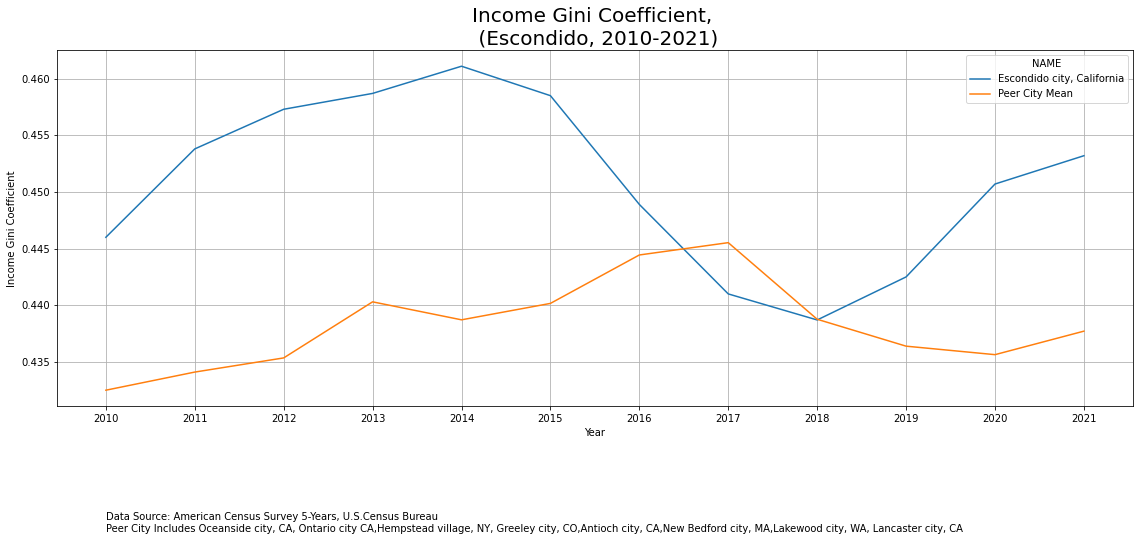

In [81]:
# use the first date as index 
#ca_auburn_2019_art = ca_auburn_2019_art.set_index('Year')
#race_pop_indexed_escondido = race_pop_indexed_escondido[3:]

#print(tmp_df_Industry_Growth)
datags.plot(figsize=(16, 8))
plt.title('Income Gini Coefficient, \n (Escondido, 2010-2021)',fontsize=20)
plt.ylabel('Income Gini Coefficient')
plt.xlabel('Year')
plt.xticks(range(0,len(datags.index)),datags.index)
plt.grid()
plt.text(0,0.42 ,'Data Source: American Census Survey 5-Years, U.S.Census Bureau\nPeer City Includes Oceanside city, CA, Ontario city CA,Hempstead village, NY, Greeley city, CO,Antioch city, CA,New Bedford city, MA,Lakewood city, WA, Lancaster city, CA',fontsize=10)
# Save
plt.tight_layout()
#plt.savefig("/Users/beaconeconomics/Desktop/City of Auburn/Presentation/Product/Indexed Industry Growth.png")
plt.show()

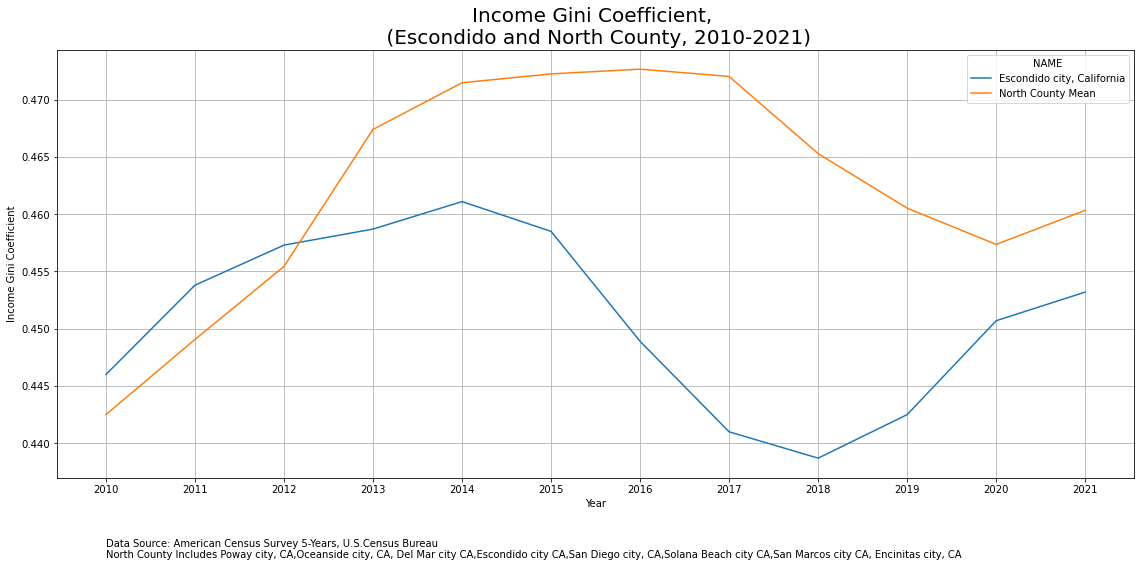

In [132]:
# use the first date as index 
#ca_auburn_2019_art = ca_auburn_2019_art.set_index('Year')
#race_pop_indexed_escondido = race_pop_indexed_escondido[3:]

#print(tmp_df_Industry_Growth)
datage.plot(figsize=(16, 8))
plt.title('Income Gini Coefficient, \n (Escondido and North County, 2010-2021)',fontsize=20)
plt.ylabel('Income Gini Coefficient')
plt.xlabel('Year')
plt.xticks(range(0,len(datags.index)),datags.index)
plt.grid()
plt.text(0,0.43 ,'Data Source: American Census Survey 5-Years, U.S.Census Bureau\nNorth County Includes Poway city, CA,Oceanside city, CA, Del Mar city CA,Escondido city CA,San Diego city, CA,Solana Beach city CA,San Marcos city CA, Encinitas city, CA',fontsize=10)
# Save
plt.tight_layout()
#plt.savefig("/Users/beaconeconomics/Desktop/City of Auburn/Presentation/Product/Indexed Industry Growth.png")
plt.show()

In [216]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from adjustText import adjust_text
plt.style.use('ggplot')

KeyError: 0

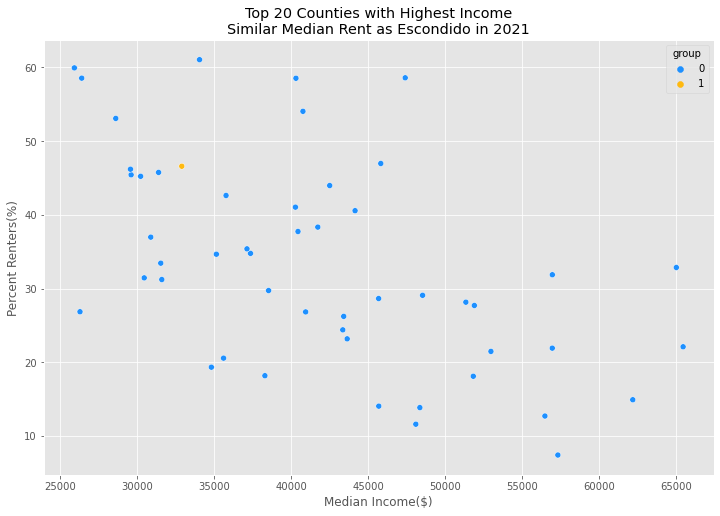

In [264]:
plt.figure(figsize=(12,8))
# Set palette
palette = ['dodgerblue', '#FFB90F']
sns.set_palette(sns.color_palette(palette))

# Scatterplot
sns.scatterplot(data=df1, x='Median_Income', y='Percent Renters', hue='group')

# Titles
plt.title('Top 20 Counties with Highest Income\nSimilar Median Rent as Escondido in 2021')
plt.xlabel('Median Income($)')
plt.ylabel('Percent Renters(%)')

# Scatter labels
texts = [plt.text(x=df1['Median_Income'][i], 
                  y=df1['Percent Renters'][i], 
                  s=df1.NAME[i], size=9) for i in range(df1.shape[0])]
adjust_text(texts)

# Axis and limits          
plt.axhline(y=df1['Median Income($)'].mean(), color='red', linestyle='--', linewidth=1, alpha=0.4)           
plt.axvline(x=df1['Percent Renters(%)'].mean(), color='red',linestyle='--', linewidth=1, alpha=0.4)

# Remove legend
plt.legend().remove()

plt.tight_layout()
plt.savefig("/Users/andrewyu/Documents/City of Ontario/Graphs/labor market/wages.png")
plt.show()

# 3.2. Save ACS file into virtual db

In [ ]:

conn = sqlite3.connect('Output/database')
acs_export = acs.copy().reset_index()
acs_export.year = acs_export.year.apply(lambda x: x.to_timestamp())


acs_export.to_sql(f'acs', conn)
conn.close()

try:

    if 'database' in os.listdir('Output'):
        conn = sqlite3.connect('Output/database')
        sql_read_df = pd.read_sql(f"select * from acs", conn, parse_dates='year').drop(['index'], axis=1)
        conn.close()
except ValueError:
    print('error,table already exists')
"""

In [ ]:

try:

    conn = sqlite3.connect("Output/database")
    cursor= conn.cursor()
    sql_read_df = pd.read_sql(f"select * from acs", conn, parse_dates='year').drop(['index'], axis=1)
    conn.close()
except ValueError:
    print('Error')

 


In [ ]:
sql_read_df 

In [ ]:
sql_read_df=sql_read_df.pivot_table(index= ['city','year'])

In [ ]:
sql_read_df.index = pd.MultiIndex.from_arrays([
    sql_read_df.index.get_level_values(0),
    pd.PeriodIndex(sql_read_df.index.get_level_values(1), freq='A')])